# Parameters

In [1]:
# PARAMETERS ##########################################

RUN     = 118           # number of run
subrun  = 0             # number of subrun

Nevents = 50            # number of events we are going to extract to plot

# path of the directory we have all the runs (runs organised by day-folders)
root = '/pnfs/pic.es/data/cta/LST/LST2/Data/ZFITS/'

# number of the LST camera we are analysing
LST_camera = 2

#######################################################

In [2]:
import numpy  as np
import matplotlib.pyplot as plt
import os 

from traitlets.config      import Config
from ctapipe.io            import EventSource
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates   import EngineeringCameraFrame


# matplotlib parameters used to do the plots
def parameters(n=20):
    plt.rcParams['mathtext.rm']         = 'Bitstream Vera Sans'
    plt.rcParams['mathtext.it']         = 'Bitstream Vera Sans:italic'
    plt.rcParams['mathtext.bf']         = 'Bitstream Vera Sans:bold'
    plt.rcParams['mathtext.fontset']    = 'stix'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams.update({"font.size": n})
    
# function to perform one event plot
def event_waveforms_plot(event_index, waveforms):
    
    event_index = event_index-1
    
    parameters()
    fig,ax = plt.subplots(figsize=(7,4)) 
    
    for px in range(len(waveforms[event_index])):
        
        # random blue color
        color = (np.random.choice(np.linspace(0.2,0.5,10)),np.random.choice(np.linspace(0,1,10)),
                 np.random.choice([0.7,0.8,0.9,1]))
        # plot the waveforms
        ax.plot(waveforms[event_index][px], color=color, alpha=0.5, lw=1.5)

    ax.set_xlabel('t (ns)')
    ax.set_ylabel('charge')

# function for searching a run in the directories
def search(root, RUN):
    
    date = None   # initially set to None in the cas the run was not found in root
    
    directories = [dirs for dirs in os.listdir(root)]  #list of all the date directories

    for dirs in directories:    # checking over all directories
        path = os.path.join(root, dirs)

        files = []
        for r, d, f in os.walk(path):
            for file in f:
                files.append(file)     # getting all the filenames

        # we want only the number of run and the number of subrun
        files = [files[i][11:-8].split('.') for i in range(len(files))]
        files = [[int(files[i][j]) for j in range(len(files[i]))]for i in range(len(files))]

        # we eliminate the repeated elements (we have 4 docs for each subrun)
        filesFilter = []
        for i in files:
            if i not in filesFilter:
                filesFilter.append(i)    
        
        runs = [filesFilter[i][0] for i in range(len(filesFilter))] # array with run number

        #checking if our run is in this directory
        if RUN in runs:
            date = dirs

            # subruns finding
            filesRun = [filesFilter[i] for i in range(len(filesFilter)) if filesFilter[i][0]==RUN]
            subruns  = [filesRun[i][1] for i in range(len(filesRun))]
            subruns.sort()
    
    if date == None:
        print('ERROR: Run not found in root')
    else:
        # return the date name and the number of subruns
        return date, subruns

# Data extraction

In [3]:
# findng to what date correspond the run
date, subruns = search(root,RUN)

# to open a second run we need to use the first subrun of the run and
# extract the timestamp of the first event

# first subrun configuration
config = Config({'LSTEventSource': {'default_trigger_type': 'ucts','allowed_tels': [1],
                                    'min_flatfield_adc': 3000,'min_flatfield_pixel_fraction': 0.8,},})  

path = root+date+'/'
path = path + 'LST-'+str(LST_camera)+'.1.Run'+str(RUN).zfill(5)+'.'+str(0).zfill(4)+'.fits.fz'
source = EventSource( input_url = path ,config = config, max_events=1)

for i, ev in enumerate(source): 
    timestamp = int(ev.trigger.time.value)

# following subrun configuration
config = Config({'LSTEventSource': {'default_trigger_type': 'ucts','allowed_tels': [1],
                                    'min_flatfield_adc': 3000,'min_flatfield_pixel_fraction': 0.8,
                                    "EventTimeCalculator": {"dragon_module_id":133,
                                                            "dragon_reference_counter": 0,
                                                            "dragon_reference_time": timestamp,},},})

path = root + date+'/LST-'+str(LST_camera)+'.1.Run'+str(RUN).zfill(5)+'.'+str(subrun).zfill(4)+'.fits.fz' 


# once we have the timestamp extracted we can take the data we wanted
source = EventSource(input_url=path ,config=config, max_events=Nevents)

# extracting the waveforms
waveforms = [[] for i in range(Nevents)]

for i, ev in enumerate(source): 
    for px in range(1855):
        waveforms[i].append(ev.r0.tel[1].waveform[0][px][5:])


Cannot calculate a precise timestamp for obs_id=118, tel_id=1. UCTS unavailable.
Using event 1 as time reference for dragon. timestamp: 1651852322000000000 from svc.date counter: 4156230000
No drive report specified, pointing info will not be filled
No drive report specified, pointing info will not be filled


# Plot 1 event only

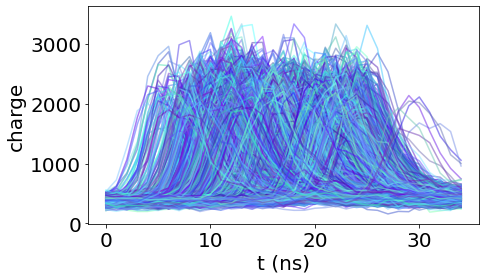

In [4]:
######################################

event_index = 12

######################################

event_waveforms_plot(event_index, waveforms)

# # for saving the plot uncomment and change the filename as you want
# plt.savefig('waveforms.pdf',format='pdf',bbox_inches='tight') 
plt.show()

# Plot multiple events

Event ID 1


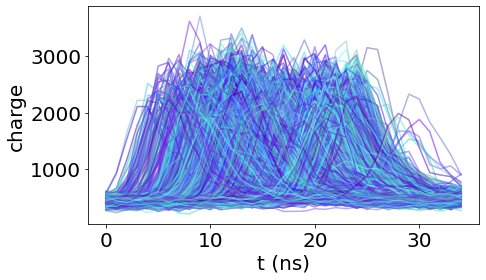

Event ID 2


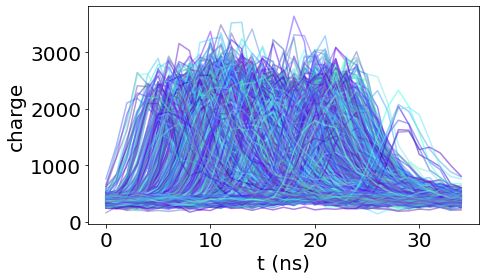

Event ID 3


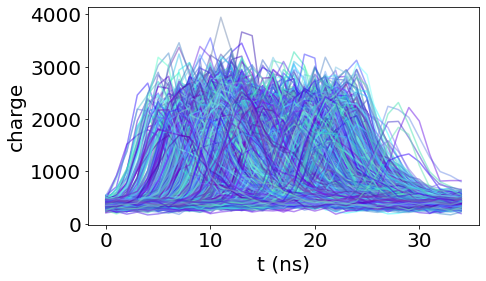

Event ID 4


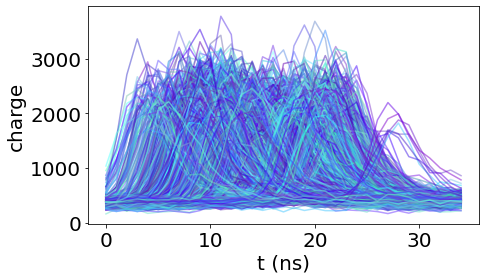

Event ID 5


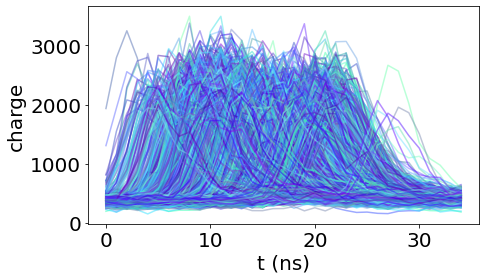

Event ID 6


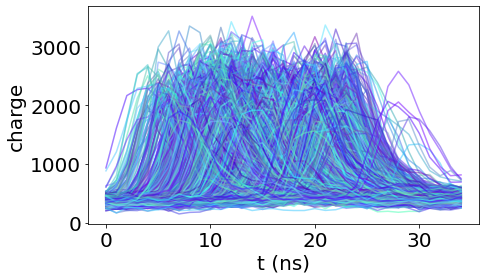

Event ID 7


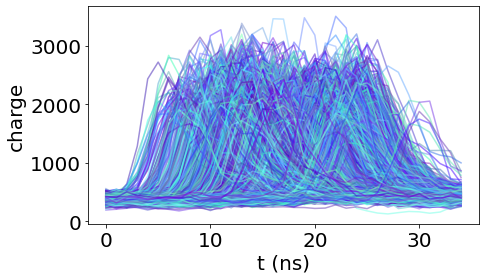

Event ID 8


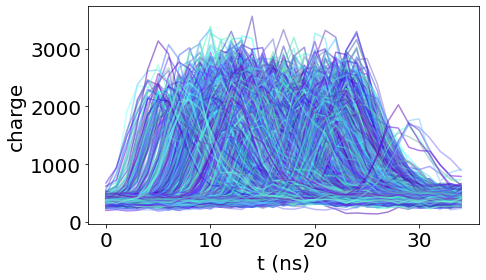

Event ID 9


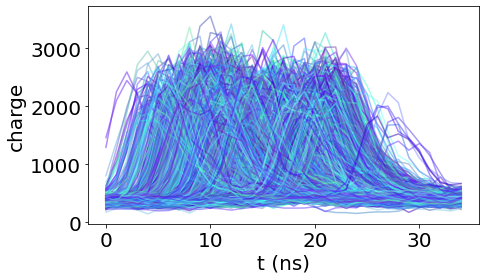

Event ID 10


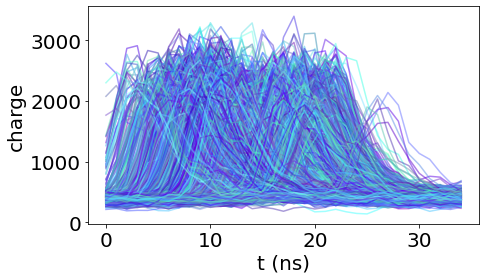

In [5]:
######################################

# create an array with all the event numbers we want to plot 
# (note: there are not eventID = 0, so start from 1)
event_indexes = np.array(range(10))+1

######################################

for ev in event_indexes:
    print('Event ID '+str(ev))
    event_waveforms_plot(ev, waveforms)
    plt.show()